<b><h3>Book Data Scraping and Price Prediction with Machine Learning</h3></b>

In this project, we will be engaging in a comprehensive data analysis and web scraping task. The project is divided into two main components: scraping data from an online source and analyzing it. In the first part, we are going to extract data from an online book catalog website using web scraping techniques. The goal is to gather useful information, such as book titles, prices, availability, and ratings, from multiple pages of the website. This will be done using Python libraries like requests and BeautifulSoup, which allow us to navigate through the website, collect the relevant data, and save it into a CSV file. The purpose of this step is to gather structured data that we can later use for analysis. Once the data is scraped, we will move to the analysis part, where we will perform exploratory data analysis (EDA) to better understand the dataset. This will include inspecting summary statistics, distribution of values, and identifying potential patterns or anomalies within the data.

In the second part of the project, we will use machine learning techniques to cluster the data and predict prices based on book ratings. Specifically, we will apply KMeans clustering and DBSCAN clustering methods to segment the data into different groups based on similarities. We will also create a polynomial regression model to predict the price of books based on their ratings. After performing the analysis, we will evaluate the effectiveness of our clustering models using metrics like silhouette scores to determine how well the clusters match the data. This project will help us understand not only how to scrape and analyze data but also how to apply machine learning techniques to make predictions and find hidden patterns within real-world data.

In [1]:
import os
import platform
import requests
import zipfile
import pandas as pd
import subprocess
from selenium import webdriver
from selenium.webdriver.edge.service import Service as EdgeService
from selenium.webdriver.edge.options import Options
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split



### Downloading Microsoft Edge Webdriver
First you have to see which version your Edge Browser is. then go ahead and set the version in the ``` version``` variable

In [2]:
def download_webdriver(os_choice, browser_choice, version):
    if os_choice == "Windows":
        driver_folder = os.getcwd()
        driver_path = os.path.join(driver_folder, f"{browser_choice.lower()}driver.exe")
        platform_suffix = "win64"
    elif os_choice == "Linux":
        driver_folder = os.getcwd()
        driver_path = os.path.join(driver_folder, f"{browser_choice.lower()}driver")
        platform_suffix = "linux64"
    elif os_choice == "Mac":
        driver_folder = os.getcwd()
        driver_path = os.path.join(driver_folder, f"{browser_choice.lower()}driver")
        platform_suffix = "mac64"
    else:
        print("Unsupported OS. Exiting.")
        return

    if not os.path.exists(driver_path):
        print(f"Downloading {browser_choice} WebDriver for {os_choice}...")
        if browser_choice == "Edge":
            download_url = f"https://msedgedriver.azureedge.net/{version}/edgedriver_{platform_suffix}.zip"
        elif browser_choice == "Chrome":
            download_url = f"https://chromedriver.storage.googleapis.com/{version}/chromedriver_{platform_suffix}.zip"
        elif browser_choice == "Firefox":
            download_url = f"https://github.com/mozilla/geckodriver/releases/download/v{version}/geckodriver-v{version}-{platform_suffix}.tar.gz"
        else:
            print("Unsupported browser. Exiting.")
            return

        response = requests.get(download_url)

        if response.status_code == 200:
            zip_file_path = os.path.join(driver_folder, f"{browser_choice.lower()}driver.zip")
            
            with open(zip_file_path, 'wb') as f:
                f.write(response.content)
            print(f"{browser_choice} WebDriver downloaded successfully.")

            try:
                with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                    zip_ref.extractall(driver_folder)
                print(f"{browser_choice} WebDriver extracted successfully.")
            except zipfile.BadZipFile:
                print("Failed to extract the zip file. The zip file may be corrupted.")
                return
            
            os.remove(zip_file_path)
            print("Zip file removed.")

            if os.path.exists(driver_path):
                try:
                    subprocess.Popen([driver_path])
                    print(f"{browser_choice} WebDriver started.")
                except Exception as e:
                    print(f"Error starting {browser_choice} WebDriver: {e}")
            else:
                print(f"Error: {browser_choice.lower()}driver not found after extraction.")
        else:
            print(f"Failed to download {browser_choice} WebDriver. Status code: {response.status_code}")
    else:
        print(f"{browser_choice} WebDriver already exists at:", driver_path)


if __name__ == "__main__":
    os_choice = input("Select OS (Windows, Linux, Mac): ").strip()
    install_driver = input("Do you want to install WebDriver? (y/n): ").strip().lower()
    if install_driver == 'y':
        browser_choice = input("Select browser (Edge, Chrome, Firefox): ").strip()
        version = input("Enter the browser version (e.g., 130.0.2849.68 for Edge, 114.0 for Chrome, etc.): ").strip()
        download_webdriver(os_choice, browser_choice, version)
    else:
        print("WebDriver installation is required to proceed. Exiting.")


Failed to download Edge WebDriver. Status code: 404


### Setting the dataset URL in order to scrape it and gather the data

In [ ]:
base_url = "http://books.toscrape.com/catalogue/page-{}.html"
csv_file = 'books_data.csv'
csv_columns = ['Title', 'Price', 'Availability', 'Rating']

with open(csv_file, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(csv_columns)

for page in range(1, 3):
    url = base_url.format(page)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    books = soup.find_all('article', class_='product_pod')
    
    for book in books:
        title = book.h3.a['title']
        price = book.find('p', class_='price_color').text.strip()
        availability = book.find('p', class_='instock availability').text.strip()
        rating_class = book.p['class'][1]
        rating = rating_class.replace('star-rating', '').strip()
        
        with open(csv_file, 'a', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow([title, price, availability, rating])

print(f"Data has been scraped and saved to {csv_file}")


Data has been scraped and saved to books_data.csv


### Loading the data

In [24]:
df = pd.read_csv('books_data.csv')
df.head()

,Title,Price,Availability,Rating
0,A Light in the Attic,Â£51.77,In stock,Three
1,Tipping the Velvet,Â£53.74,In stock,One
2,Soumission,Â£50.10,In stock,One
3,Sharp Objects,Â£47.82,In stock,Four
4,Sapiens: A Brief History of Humankind,Â£54.23,In stock,Five


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         40 non-null     object
 1   Price         40 non-null     object
 2   Availability  40 non-null     object
 3   Rating        40 non-null     object
dtypes: object(4)
memory usage: 1.4+ KB


### this is what we would do
1. Clean the Price column
The price data is in string format (e.g., "£51.77"), so we should convert it into a numeric format by removing the currency symbol and converting the remaining part to a float.

2. Clean the Availability column
The availability data has excess whitespace. We need to remove any extra spaces or unwanted characters.

3. Clean the Rating column
The rating column contains class-based information such as "star-rating One", "star-rating Two", etc. We can extract just the numeric value of the rating (e.g., "One" becomes 1, "Two" becomes 2, etc.).

We explicitly remove Â characters by adding Â: '' in the replace() function.
We also use pd.to_numeric() with the errors='coerce' parameter, which will convert non-numeric values to NaN (missing data).
We check for any remaining non-numeric values in the Price column and handle them by setting them to None (or NaN).

In [ ]:
df['Price'] = df['Price'].replace({'£': '', '€': '', '$': '', ',': '', 'Â': ''}, regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Price'] = df['Price'].apply(lambda x: x if isinstance(x, (int, float)) else None)

df['Availability'] = df['Availability'].str.strip()

rating_map = {
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4,
    'Five': 5
}
df['Rating'] = df['Rating'].str.replace('star-rating ', '').map(rating_map)

df.head()


,Title,Price,Availability,Rating
0,A Light in the Attic,51.77,In stock,3
1,Tipping the Velvet,53.74,In stock,1
2,Soumission,50.10,In stock,1
3,Sharp Objects,47.82,In stock,4
4,Sapiens: A Brief History of Humankind,54.23,In stock,5


### Some Statistics of the dataset

In [ ]:
print("Summary Statistics")

print("\nPrice Summary:")
print(df['Price'].describe())

print("\nRating Summary:")
print(df['Rating'].describe())

print("\nAvailability Counts:")
print(df['Availability'].value_counts())

print("\nData Types:")
print(df.dtypes)

print("\nUnique Titles:")
print(df['Title'].nunique())

print("\nFirst few rows of data:")
print(df.head())


Summary Statistics

Price Summary:
count    40.000000
mean     34.958750
std      14.111908
min      12.840000
25%      22.575000
50%      34.080000
75%      50.407500
max      57.250000
Name: Price, dtype: float64

Rating Summary:
count    40.000000
mean      3.050000
std       1.501282
min       1.000000
25%       2.000000
50%       3.000000
75%       4.250000
max       5.000000
Name: Rating, dtype: float64

Availability Counts:
Availability
In stock    40
Name: count, dtype: int64

Data Types:
Title            object
Price           float64
Availability     object
Rating            int64
dtype: object

Unique Titles:
40

First few rows of data:
                                   Title  Price Availability  Rating
0                   A Light in the Attic  51.77     In stock       3
1                     Tipping the Velvet  53.74     In stock       1
2                             Soumission  50.10     In stock       1
3                          Sharp Objects  47.82     In stock       4

Visualizing Summary Stats and EDA with Multiple Plots
We will create a series of plots to visualize the summary statistics, data distribution, and relationships.

Plots for Numerical Features (Price and Rating):
We'll plot histograms, box plots, and other visualizations to understand the distribution of data.

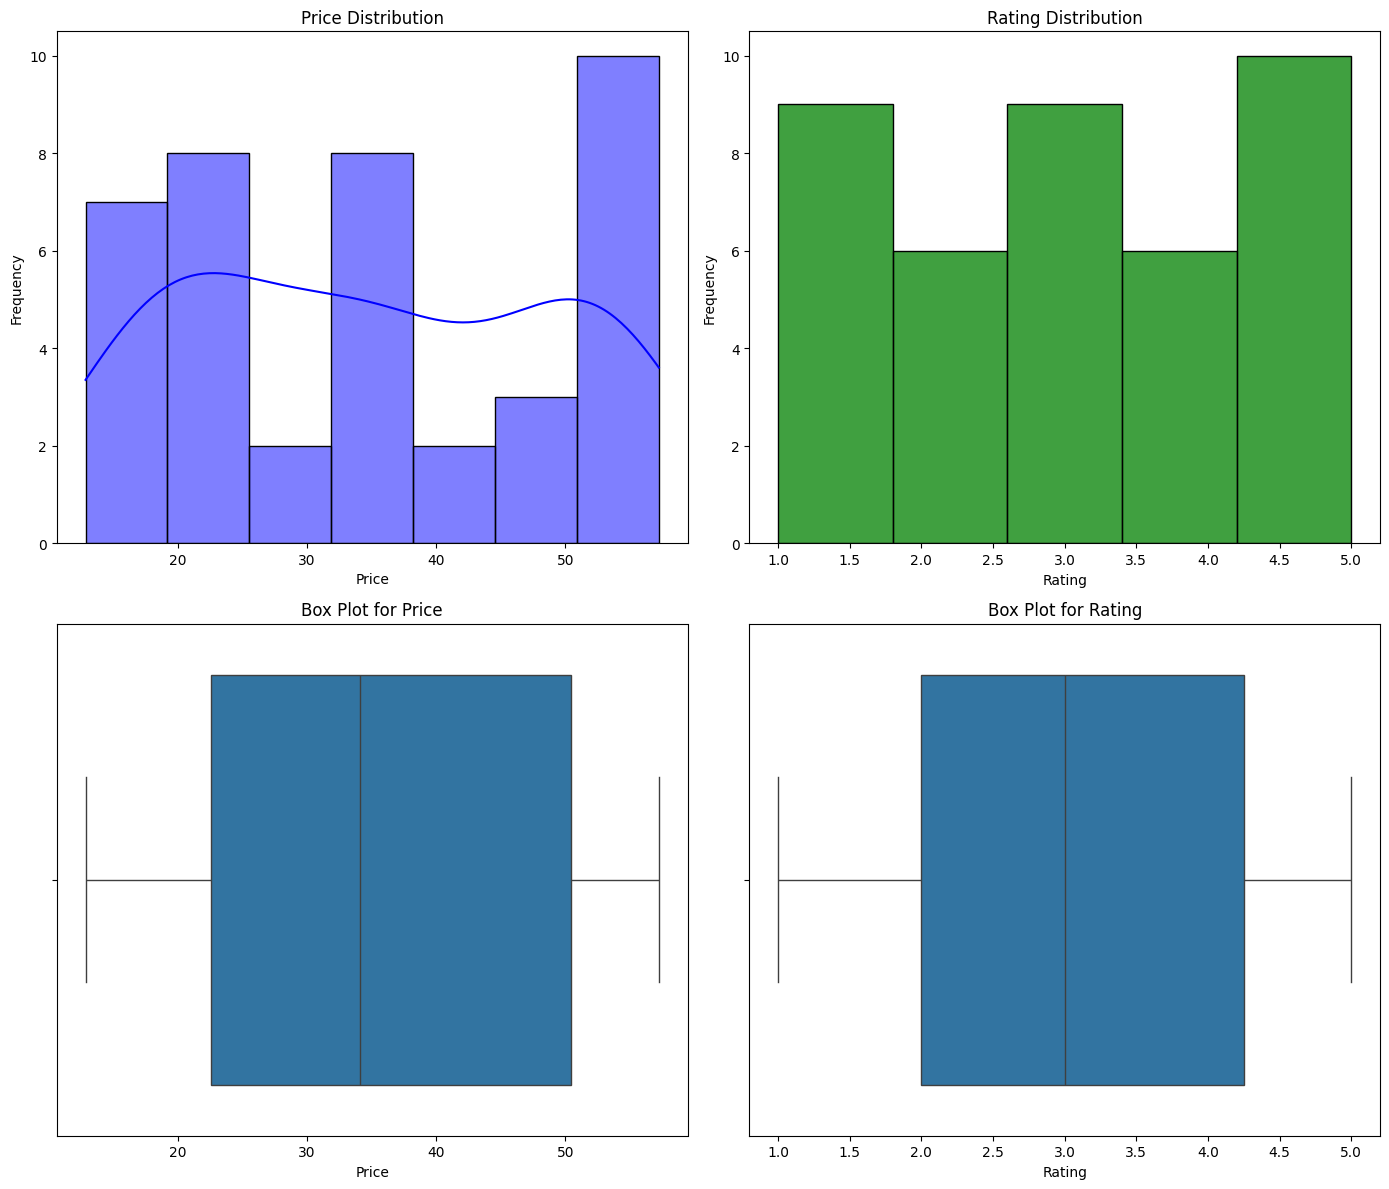

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

sns.histplot(df['Price'], kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frequency')


sns.histplot(df['Rating'], kde=False, color='green', ax=axes[0, 1], bins=5)
axes[0, 1].set_title('Rating Distribution')
axes[0, 1].set_xlabel('Rating')
axes[0, 1].set_ylabel('Frequency')

sns.boxplot(x=df['Price'], ax=axes[1, 0])
axes[1, 0].set_title('Box Plot for Price')


sns.boxplot(x=df['Rating'], ax=axes[1, 1])
axes[1, 1].set_title('Box Plot for Rating')


plt.tight_layout()
plt.show()


Correlation Heatmap for Numerical Features:
After cleaning the data and converting the necessary columns (like Price and Rating) to numeric types, we can calculate and visualize the correlation between numerical columns.

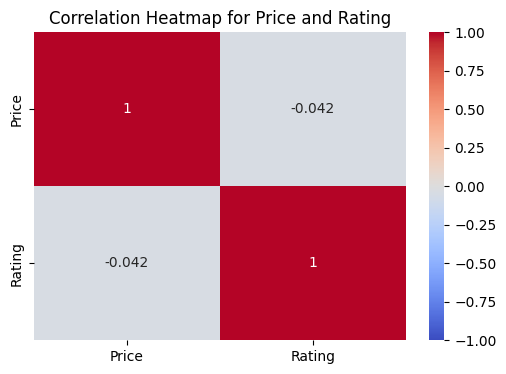

In [ ]:

correlation = df[['Price', 'Rating']].corr()


plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Price and Rating')
plt.show()


Availability Data:
We can check the distribution of availability (e.g., whether items are in stock or not) to gain further insights.

C:\Users\Vortex\AppData\Local\Temp\ipykernel_15152\1280967670.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Availability', palette='viridis')


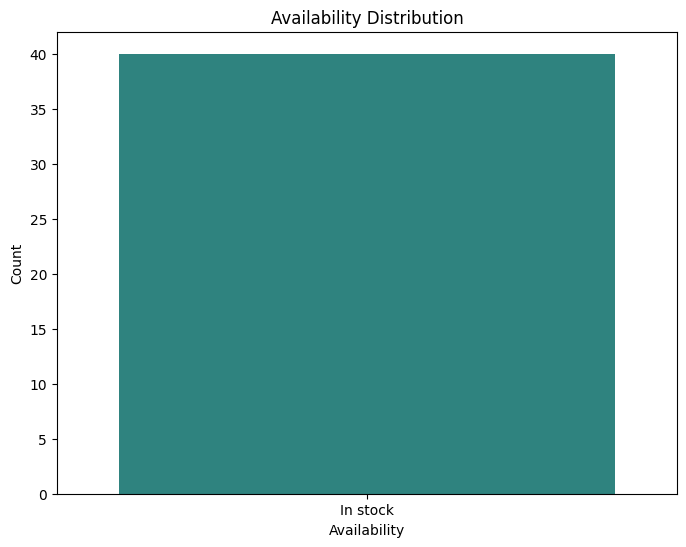

In [ ]:

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Availability', palette='viridis')
plt.title('Availability Distribution')
plt.xlabel('Availability')
plt.ylabel('Count')
plt.show()


Outliers and Anomalies Detection:

We'll detect outliers for both Price and Rating using boxplots, as this can often provide insight into any unusual data points.

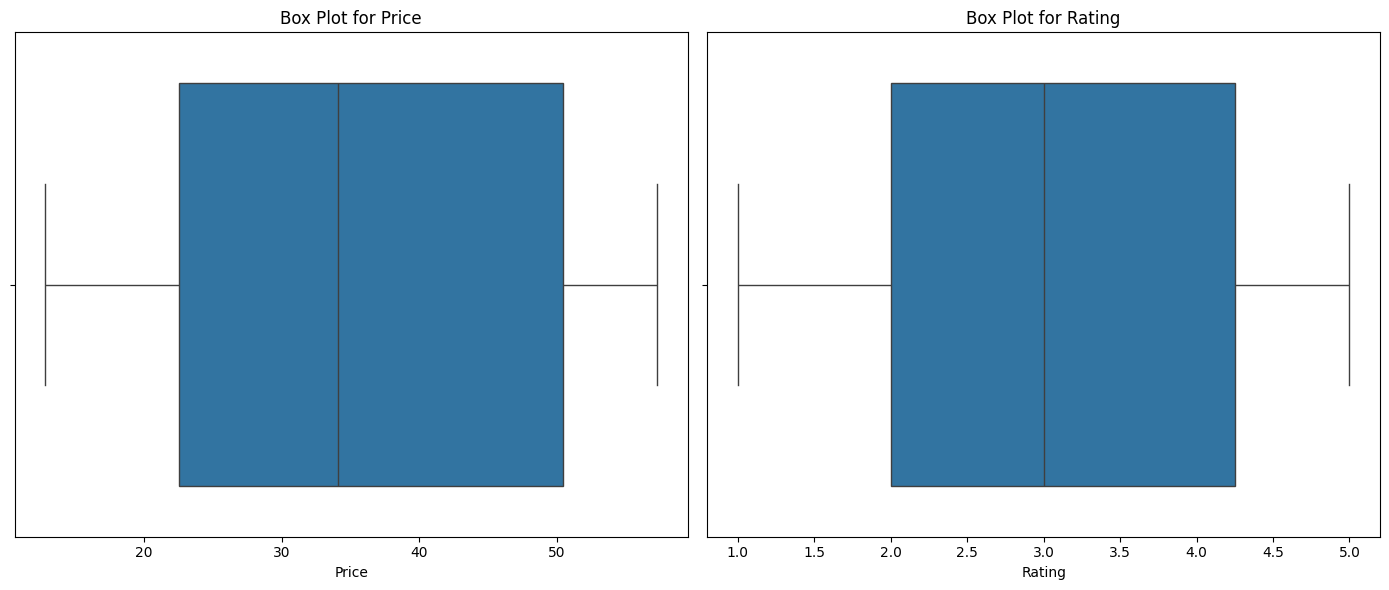

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.boxplot(x=df['Price'], ax=axes[0])
axes[0].set_title('Box Plot for Price')


sns.boxplot(x=df['Rating'], ax=axes[1])
axes[1].set_title('Box Plot for Rating')

plt.tight_layout()
plt.show()


### Categoring the data 

In [ ]:

def price_category(price):
    if price < 10:
        return 'Low'
    elif 10 <= price < 50:
        return 'Medium'
    else:
        return 'High'

df['Price_Category'] = df['Price'].apply(price_category)

# Check the new feature
print("\nPrice Category Counts:")
print(df['Price_Category'].value_counts())



Price Category Counts:
Price_Category
Medium    29
High      11
Name: count, dtype: int64


#### Pairplot of Price and Rating columns

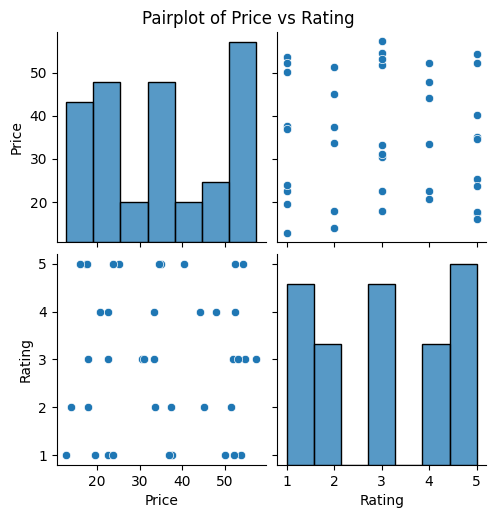

In [ ]:

sns.pairplot(df[['Price', 'Rating']])
plt.suptitle('Pairplot of Price vs Rating', y=1.02)
plt.show()


This code creates two plots: a scatterplot showing the relationship between "Price" and "Rating" colored by "Price_Category," and a violin plot displaying the distribution of "Price" for each "Rating."

C:\Users\Vortex\AppData\Local\Temp\ipykernel_15152\1174437439.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Rating', y='Price', palette='coolwarm', ax=axes[1])


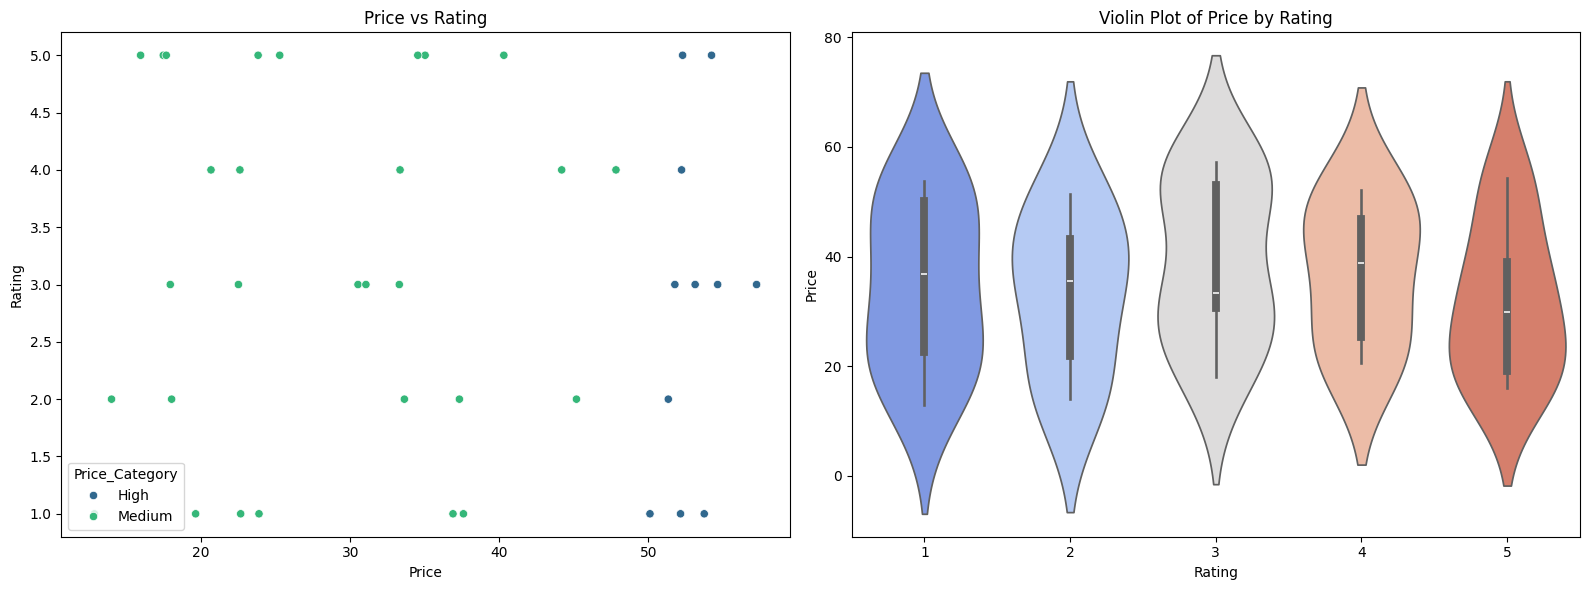

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data=df, x='Price', y='Rating', hue='Price_Category', palette='viridis', ax=axes[0])
axes[0].set_title('Price vs Rating')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Rating')

sns.violinplot(data=df, x='Rating', y='Price', palette='coolwarm', ax=axes[1])
axes[1].set_title('Violin Plot of Price by Rating')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Price')


plt.tight_layout()
plt.show()


<h1>Machine learning algorithms</h1>

**Hypothesis:**  
My hypothesis is that the clusters created by KMeans and DBSCAN algorithms might align with similar price categories. In other words, items within the same price range are likely to belong to the same cluster. I aim to examine this alignment by clustering the data with these two algorithms.

**Experimental Analysis:**  
To test this, I first clustered the data using KMeans and DBSCAN algorithms. Then, I used contingency tables to analyze the count of items within each cluster and each price category. Afterward, I performed a Chi-square test to see if there’s a statistically significant association between clusters and price categories. If the Chi-square test yields a p-value below 0.05, it would indicate a meaningful relationship between clusters and price categories. Additionally, I used the Silhouette Score to evaluate cluster quality, ensuring that the clustering algorithms are producing reasonable results.

<div direction='rtl' style='text-align:right'>فرضیه‌ای که دارم اینه که ممکنه خوشه‌هایی که با الگوریتم‌های KMeans یا DBSCAN ایجاد می‌شن، با دسته‌بندی‌های قیمتی مشابه هم‌راستا باشن. یعنی احتمالاً کالاهایی که توی رنج قیمت مشابه قرار دارن، در یک خوشه مشابه قرار می‌گیرن. این رو با استفاده از خوشه‌بندی این دو الگوریتم می‌خوام بررسی کنم.</div>

<div direction='rtl' style='text-align:right'>
برای این کار، اول داده‌ها رو با استفاده از الگوریتم‌های KMeans و DBSCAN خوشه‌بندی کردم. بعد با استفاده از جدول‌های تقاطعی، تعداد کالاهایی که توی هر خوشه و هر دسته‌بندی قیمتی قرار دارن، بررسی می‌کنم. بعد از این، آزمون کای‌دو انجام میدم تا ببینم ارتباطی بین خوشه‌ها و دسته‌بندی قیمت‌ها وجود داره یا نه. اگر نتیجه آزمون کای‌دو نشان بده که p-value کمتر از ۰.۰۵ هست، یعنی خوشه‌ها با دسته‌بندی قیمت‌ها ارتباط معناداری دارن. همچنین برای ارزیابی کیفیت خوشه‌ها از امتیاز سیلوئت (Silhouette Score) استفاده می‌کنم تا مطمئن بشم که الگوریتم‌های خوشه‌بندی نتایج معقولی میدن.
</div>

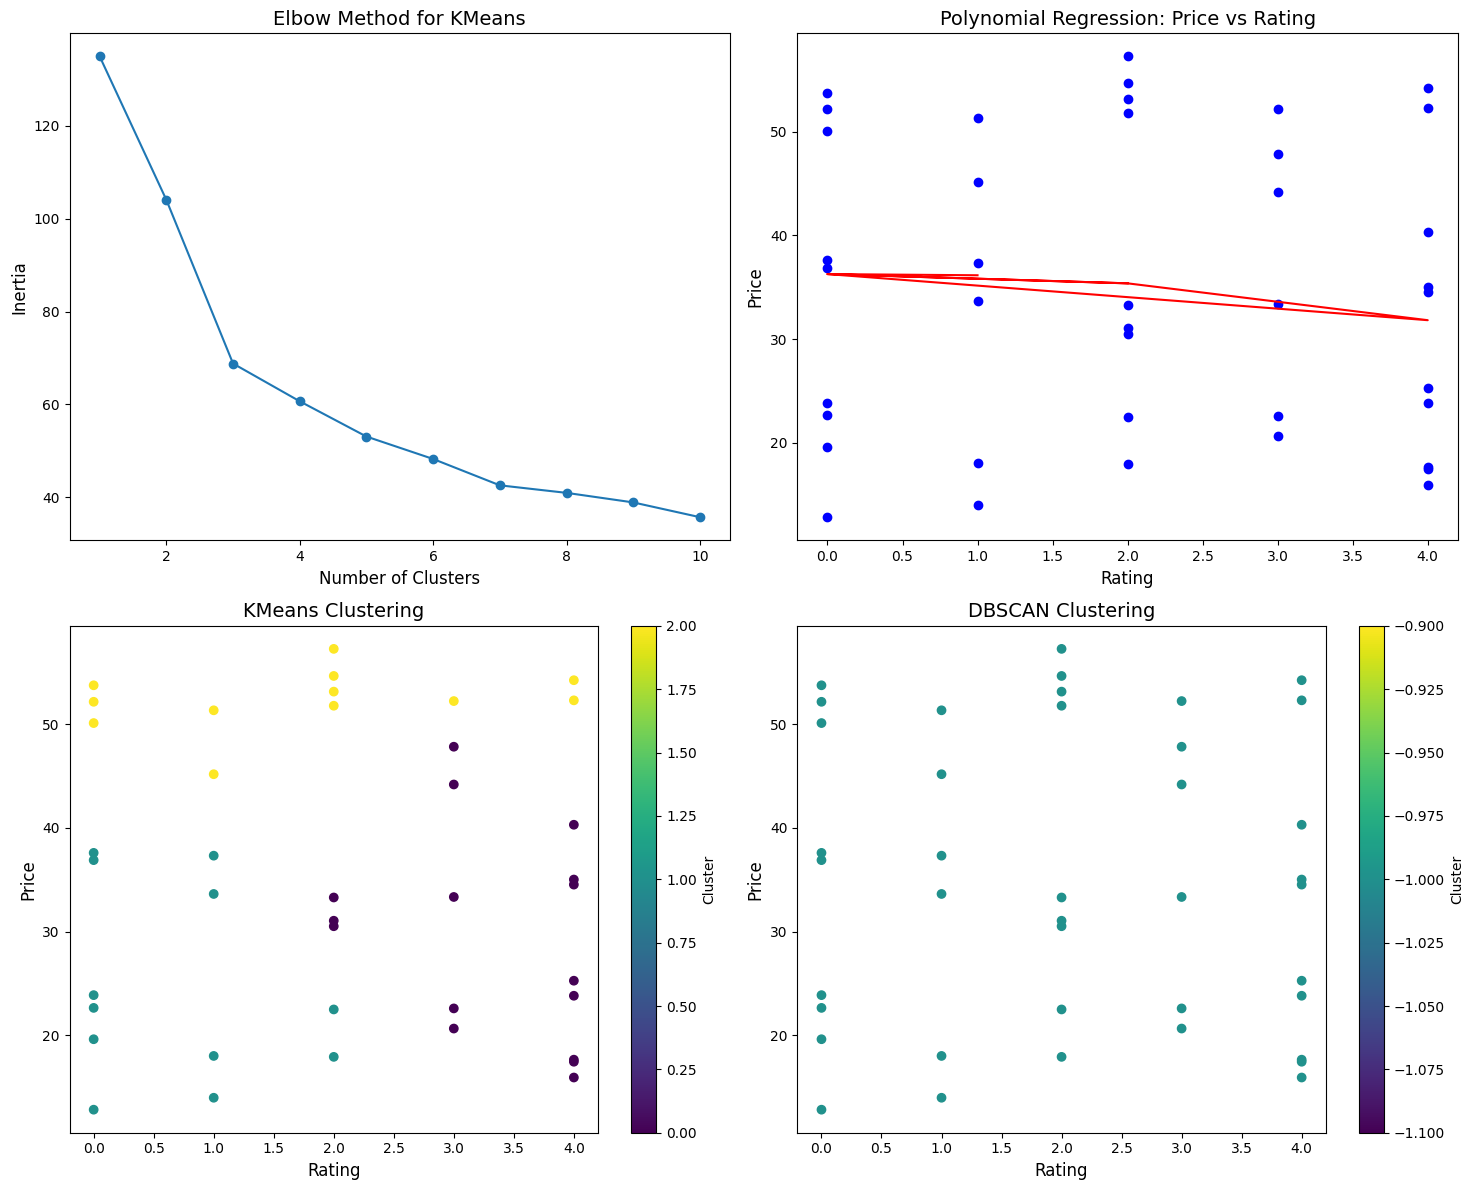

KMeans Silhouette Score: 0.25221527699274554
DBSCAN did not create at least two clusters, silhouette score cannot be calculated.
KMeans Cluster vs Price Category:
Price Category  High  Medium
Cluster                     
0                  0      16
1                  0      12
2                 11       1
DBSCAN Cluster vs Price Category:
Price Category  High  Medium
Cluster                     
-1                11      29
Chi-Square Test for KMeans: p-value = 2.0534705617494824e-08
Chi-Square Test for DBSCAN: p-value = 1.0
KMeans Silhouette Score: 0.25221527699274554
DBSCAN did not create at least two clusters, silhouette score cannot be calculated.


In [69]:
categorical_cols = ['Title', 'Availability', 'Price_Category']
numerical_cols = ['Rating', 'Price']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

X = preprocessor.fit_transform(df)

inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for KMeans", fontsize=14)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Inertia", fontsize=12)

X_poly = df[['Rating']]
y = df['Price']
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

poly_regressor = LinearRegression()
poly_regressor.fit(X_train, y_train)
y_pred = poly_regressor.predict(X_test)

plt.subplot(2, 2, 2)
plt.scatter(df['Rating'], df['Price'], color='blue')
plt.plot(X_test[:, 1], y_pred, color='red')
plt.title("Polynomial Regression: Price vs Rating", fontsize=14)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Price", fontsize=12)

kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X)

df['KMeans_Cluster'] = labels_kmeans

dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X)

df['DBSCAN_Cluster'] = labels_dbscan

plt.subplot(2, 2, 3)
plt.scatter(df['Rating'], df['Price'], c=df['KMeans_Cluster'], cmap='viridis')
plt.title("KMeans Clustering", fontsize=14)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.colorbar(label='Cluster')

plt.subplot(2, 2, 4)
plt.scatter(df['Rating'], df['Price'], c=df['DBSCAN_Cluster'], cmap='viridis')
plt.title("DBSCAN Clustering", fontsize=14)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

sil_score_kmeans = silhouette_score(X, labels_kmeans)
print(f"KMeans Silhouette Score: {sil_score_kmeans}")

if len(np.unique(labels_dbscan)) > 1:
    sil_score_dbscan = silhouette_score(X, labels_dbscan)
    print(f"DBSCAN Silhouette Score: {sil_score_dbscan}")
else:
    print("DBSCAN did not create at least two clusters, silhouette score cannot be calculated.")

kmeans_ct = pd.crosstab(df['KMeans_Cluster'], df['Price_Category'], 
                        rownames=['Cluster'], colnames=['Price Category'])
print("KMeans Cluster vs Price Category:")
print(kmeans_ct)

dbscan_ct = pd.crosstab(df['DBSCAN_Cluster'], df['Price_Category'], 
                        rownames=['Cluster'], colnames=['Price Category'])
print("DBSCAN Cluster vs Price Category:")
print(dbscan_ct)

from scipy.stats import chi2_contingency

chi2_kmeans, p_kmeans, _, _ = chi2_contingency(kmeans_ct)
print(f"Chi-Square Test for KMeans: p-value = {p_kmeans}")

chi2_dbscan, p_dbscan, _, _ = chi2_contingency(dbscan_ct)
print(f"Chi-Square Test for DBSCAN: p-value = {p_dbscan}")

sil_score_kmeans = silhouette_score(X, df['KMeans_Cluster'])
print(f"KMeans Silhouette Score: {sil_score_kmeans}")

if len(np.unique(df['DBSCAN_Cluster'])) > 1:
    sil_score_dbscan = silhouette_score(X, df['DBSCAN_Cluster'])
    print(f"DBSCAN Silhouette Score: {sil_score_dbscan}")
else:
    print("DBSCAN did not create at least two clusters, silhouette score cannot be calculated.")
